In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import sklearn.preprocessing as prep
import warnings
import logging
import sklearn.covariance as cov
from scipy.stats import chi2
from itertools import product
import seaborn as sns
import random
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
import pandas_profiling
from pandas_profiling import ProfileReport
import phik
from phik import resources, report
from sklearn.metrics import accuracy_score, confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

### Завантаження даних

In [2]:
df = pd.read_csv('train.csv')
in_len = len(df)
df.head(3)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2


In [3]:
df_test = pd.read_csv('test.csv')
df_test.head(3)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,...,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,...,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,...,0,0,0,0,0,0,0,0,0,0


### Ознаки в датасеті

* Elevation - Elevation in meters
* Aspect - Aspect in degrees azimuth
* Slope - Slope in degrees
* Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
* Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
* Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
* Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
* Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
* Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
* Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
* Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
* Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
* Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

---

The wilderness areas are:
* 1 - Rawah Wilderness Area
* 2 - Neota Wilderness Area
* 3 - Comanche Peak Wilderness Area
* 4 - Cache la Poudre Wilderness Area

***

The soil types are:
* 1 Cathedral family - Rock outcrop complex, extremely stony.
* 2 Vanet - Ratake families complex, very stony.
* 3 Haploborolis - Rock outcrop complex, rubbly.
* 4 Ratake family - Rock outcrop complex, rubbly.
* 5 Vanet family - Rock outcrop complex complex, rubbly.
* 6 Vanet - Wetmore families - Rock outcrop complex, stony.
* 7 Gothic family.
* 8 Supervisor - Limber families complex.
* 9 Troutville family, very stony.
* 10 Bullwark - Catamount families - Rock outcrop complex, rubbly.
* 11 Bullwark - Catamount families - Rock land complex, rubbly.
* 12 Legault family - Rock land complex, stony.
* 13 Catamount family - Rock land - Bullwark family complex, rubbly.
* 14 Pachic Argiborolis - Aquolis complex.
* 15 unspecified in the USFS Soil and ELU Survey.
* 16 Cryaquolis - Cryoborolis complex.
* 17 Gateview family - Cryaquolis complex.
* 18 Rogert family, very stony.
* 19 Typic Cryaquolis - Borohemists complex.
* 20 Typic Cryaquepts - Typic Cryaquolls complex.
* 21 Typic Cryaquolls - Leighcan family, till substratum complex.
* 22 Leighcan family, till substratum, extremely bouldery.
* 23 Leighcan family, till substratum - Typic Cryaquolls complex.
* 24 Leighcan family, extremely stony.
* 25 Leighcan family, warm, extremely stony.
* 26 Granile - Catamount families complex, very stony.
* 27 Leighcan family, warm - Rock outcrop complex, extremely stony.
* 28 Leighcan family - Rock outcrop complex, extremely stony.
* 29 Como - Legault families complex, extremely stony.
* 30 Como family - Rock land - Legault family complex, extremely stony.
* 31 Leighcan - Catamount families complex, extremely stony.
* 32 Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
* 33 Leighcan - Catamount families - Rock outcrop complex, extremely stony.
* 34 Cryorthents - Rock land complex, extremely stony.
* 35 Cryumbrepts - Rock outcrop - Cryaquepts complex.
* 36 Bross family - Rock land - Cryumbrepts complex, extremely stony.
* 37 Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
* 38 Leighcan - Moran families - Cryaquolls complex, extremely stony.
* 39 Moran family - Cryorthents - Leighcan family complex, extremely stony.
* 40 Moran family - Cryorthents - Rock land complex, extremely stony.

### 1. Вивчення датасету, форматування, очистка

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

Усі стовпчики мають тип _int64_, _NaN_ відсутні

In [5]:
df.describe(percentiles=[0.05, 0.95])

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
5%,756.95000,2117.000000,13.000000,5.000000,0.000000,-4.000000,242.000000,151.000000,175.000000,53.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
95%,14364.05000,3397.000000,344.000000,32.000000,631.000000,176.000000,4635.100000,250.000000,250.000000,207.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


Привертають увагу мінімальні від'ємні значення відстаней, бінарність ознак _Soil_Type_ та _Wilderness_Area_

Визначимо стовпчики, в яких кількість значень більше двох

In [6]:
for col in df.columns:
    if df[col].nunique()>5:
        print('{}: {}'.format(df[col].name, df[col].nunique()))

Id: 15120
Elevation: 1665
Aspect: 361
Slope: 52
Horizontal_Distance_To_Hydrology: 400
Vertical_Distance_To_Hydrology: 423
Horizontal_Distance_To_Roadways: 3250
Hillshade_9am: 176
Hillshade_Noon: 141
Hillshade_3pm: 247
Horizontal_Distance_To_Fire_Points: 2710
Cover_Type: 7


Унікальні значення кількістю більше 5 містяться лише в незначній кількості стовпчиків з загальної кількості.

In [7]:
for col in df.columns:
    if df[col].nunique()<5:
        print('{}: {}'.format(df[col].name, df[col].nunique()))

Wilderness_Area1: 2
Wilderness_Area2: 2
Wilderness_Area3: 2
Wilderness_Area4: 2
Soil_Type1: 2
Soil_Type2: 2
Soil_Type3: 2
Soil_Type4: 2
Soil_Type5: 2
Soil_Type6: 2
Soil_Type7: 1
Soil_Type8: 2
Soil_Type9: 2
Soil_Type10: 2
Soil_Type11: 2
Soil_Type12: 2
Soil_Type13: 2
Soil_Type14: 2
Soil_Type15: 1
Soil_Type16: 2
Soil_Type17: 2
Soil_Type18: 2
Soil_Type19: 2
Soil_Type20: 2
Soil_Type21: 2
Soil_Type22: 2
Soil_Type23: 2
Soil_Type24: 2
Soil_Type25: 2
Soil_Type26: 2
Soil_Type27: 2
Soil_Type28: 2
Soil_Type29: 2
Soil_Type30: 2
Soil_Type31: 2
Soil_Type32: 2
Soil_Type33: 2
Soil_Type34: 2
Soil_Type35: 2
Soil_Type36: 2
Soil_Type37: 2
Soil_Type38: 2
Soil_Type39: 2
Soil_Type40: 2


Більшість ознак є бінарними. Скоріш за все це результат використання _OneHotEncoder_

Створимо субсет даних, коли входять тільки стовпчики з великою кількістю унікальних значень. Мультиколінеарність будемо визначати на цьому датасеті.

In [8]:
manyN = [col for col in df.columns if df[col].nunique() > 5]
df_many = df[manyN].copy()
df_many.head(4)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,2


In [9]:
df_many.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,7.000000


In [10]:
profile = ProfileReport(df_many, 'Profile report', explorative=True)
profile.to_widgets()
profile.to_file("profile.html")

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Можна бачити суттєву кореляцію _Hillside_at_, а також _викиди_ в стовпчиках _Horizontal_Distance_To_Hydrology, 
Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Fire_Points_.
Довикидів відносяться від'ємні значення та значення, що знаходяться за межами 5-го и 95-го персентілей.

__Виводи розділу__    
1. Частина змінних є бінарними: результат дії _OneHotEncoder_.    
2. Треба видалити ряд викиди в стовпчиках _Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Fire_Points_.   
3. Треба видалити мультиколінеарні змінні.

### Перетворення даних

Створимо "коротку" таблицю, що має стовпчики категоріальних змінних замість dummies.

In [11]:
soil_types = ['Soil_Type' + str(n) for n in range(1, 41)]
df_soils = df[soil_types].copy()
df_soils['Soil_Type'] = (df_soils.iloc[:, 0:39] == 1).idxmax(1)
df_many['Soil_Type'] = df_soils['Soil_Type'].str.replace('Soil_Type', '').astype('int8')

In [12]:
wa = ['Wilderness_Area'  + str(n) for n in range(1, 5)]
df_wa = df[wa].copy()
df_wa['Wilderness_Area'] = (df_wa.iloc[:, 0:4] == 1).idxmax(1)
df_many['Wilderness_Area'] = df_wa['Wilderness_Area'].str.replace('Wilderness_Area', '').astype('int8')

In [13]:
df_many.head(3)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area
0,1,2596,51,3,258,0,510,221,232,148,6279,5,29,1
1,2,2590,56,2,212,-6,390,220,235,151,6225,5,29,1
2,3,2804,139,9,268,65,3180,234,238,135,6121,2,12,1


Для подальшого аналізу та зручності EDA отримали "коротку" таблицю

Видалимо викиди за міркуваннями, що були наведені вище

__Робота з від'ємними значеннями__

In [14]:
for col in manyN:
    df = df.loc[df[col] >= 0].copy()
    df_many = df_many.loc[df_many[col] >= 0].copy()

__Робота з персентілямі__

In [15]:
def outliers_IQR(df, col, multiplier):
    quartile_1 = np.percentile(df[col], 25)
    quartile_3 = np.percentile(df[col], 75)
    
    IQR = np.abs(quartile_3 - quartile_1)
    
    min_value = quartile_1 - multiplier * IQR
    max_value = quartile_3 + multiplier * IQR
    
    outliers_col = [item for item in manyN if item not in ['Id', 'Cover_Type']]
    outliers_col_many = [item for item in manyN if item not in ['Id', 'Cover_Type', 'Soil_Type', 'Wilderness_Area']]
    
    col_clear = df[col].loc[(df[col] > min_value) & (df[col] < max_value)].copy()
    cleared = len(df) - len(col_clear)
    
    return cleared, min_value, max_value

Визначимо кількість спостережень, що знаходяться за межами інтерквартильної відстані: _[q1 - 1.5*IQR; q3 + 1.5*IQR]_

In [16]:
cols = [item for item in manyN if item not in ['Cover_Type', 'Id']]
for col in cols:
    print('{} has {} викидів'.format(col, outliers_IQR(df, col, 1.5)[0]))

Elevation has 0 викидів
Aspect has 0 викидів
Slope has 71 викидів
Horizontal_Distance_To_Hydrology has 489 викидів
Vertical_Distance_To_Hydrology has 490 викидів
Horizontal_Distance_To_Roadways has 813 викидів
Hillshade_9am has 355 викидів
Hillshade_Noon has 373 викидів
Hillshade_3pm has 113 викидів
Horizontal_Distance_To_Fire_Points has 603 викидів


Видалимо такі спостереження у трьох стовпчиках:
* Vertical_Distance_To_Hydrology
* Horizontal_Distance_To_Roadways
* Hillshade_9am

In [17]:
to_clear = ['Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am']

In [18]:
for col in to_clear:
    _, min_v, max_v = outliers_IQR(df, col, 1.5)
    df = df.loc[(df[col] > min_v) & (df[col] < max_v)].copy()
    df_many = df_many.loc[(df_many[col] > min_v) & (df_many[col] < max_v)].copy()

In [19]:
print('Після видалення викидів залишилося {}, що складає {:.1f}% від початкової кількості'.format(len(df), len(df) / in_len * 100))

Після видалення викидів залишилося 12430, що складає 82.2% від початкової кількості


### EDA (Exploratory Data Analyzis)

Побудуємо розподіл таргетної змінної (до видалення викидів розподіл був рівним, зараз невеликі коливання кількості)

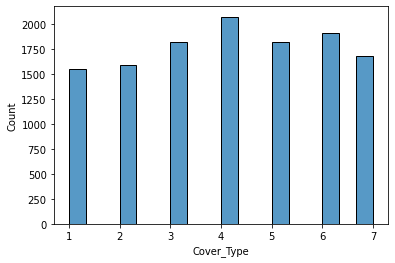

In [20]:
fig, ax = plt.subplots()
sns.histplot(df.Cover_Type, ax=ax)
plt.show()

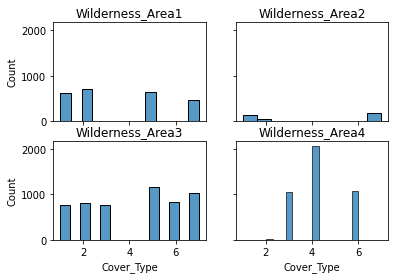

In [21]:
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)
for n, ax in enumerate(axs.flatten()):
    col = 'Wilderness_Area' + str(n + 1)
    df_loc = df.loc[df[col] == 1].copy()
    sns.histplot(df_loc.Cover_Type, ax=ax)
    ax.set_title(col)

Wilderness area є суттєсової ознакою, від якої залежить таргетна змінна.

Аналізуємо залежність таргетної змінної від _Soil_Type_

In [22]:
df_many['count'] = 1
df_g = df_many.groupby(['Cover_Type', 'Soil_Type']).agg({'count': np.sum})
df_g.reset_index(inplace=True)

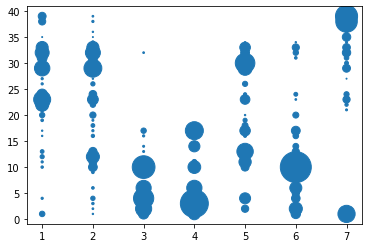

In [23]:
plt.scatter(df_g.Cover_Type, df_g.Soil_Type, s=df_g['count'])

Як можна бачити, існує залежність _Cover_Type_ від типу грунту

__Залежність _Cover_Type_ від нумеричних параметрів__

In [24]:
num_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
            'Horizontal_Distance_To_Fire_Points']

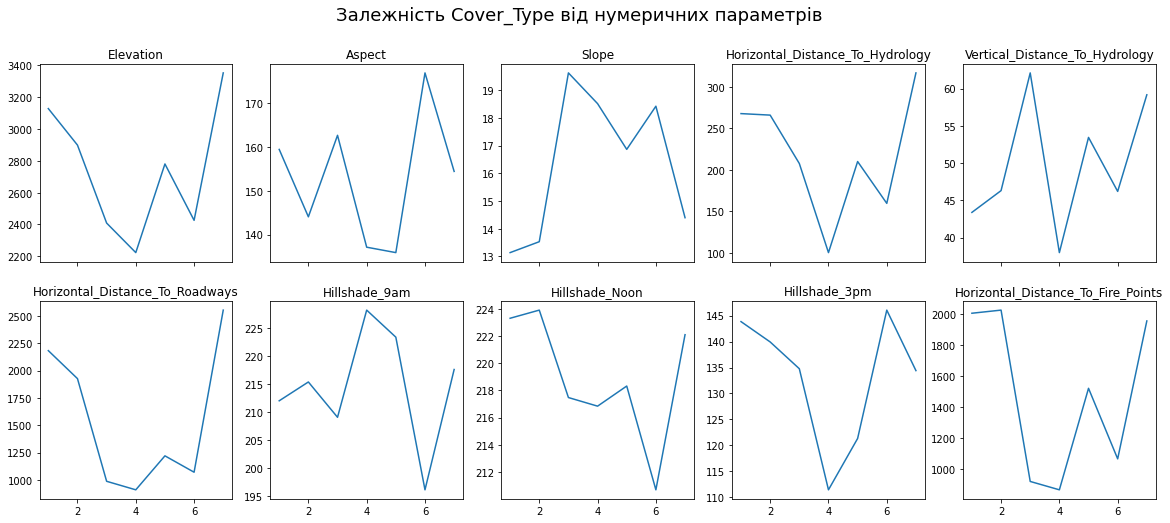

In [25]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8), sharex=True)
df_g = df.groupby('Cover_Type').agg({col:np.mean for col in num_cols})
for col, ax in zip(num_cols, axs.flatten()):
    ax.plot(df_g.index, df_g[col])
    ax.set_title(col)
plt.suptitle('Залежність Cover_Type від нумеричних параметрів', fontsize=18)
plt.show()

__Попарні співвідношення змінних__

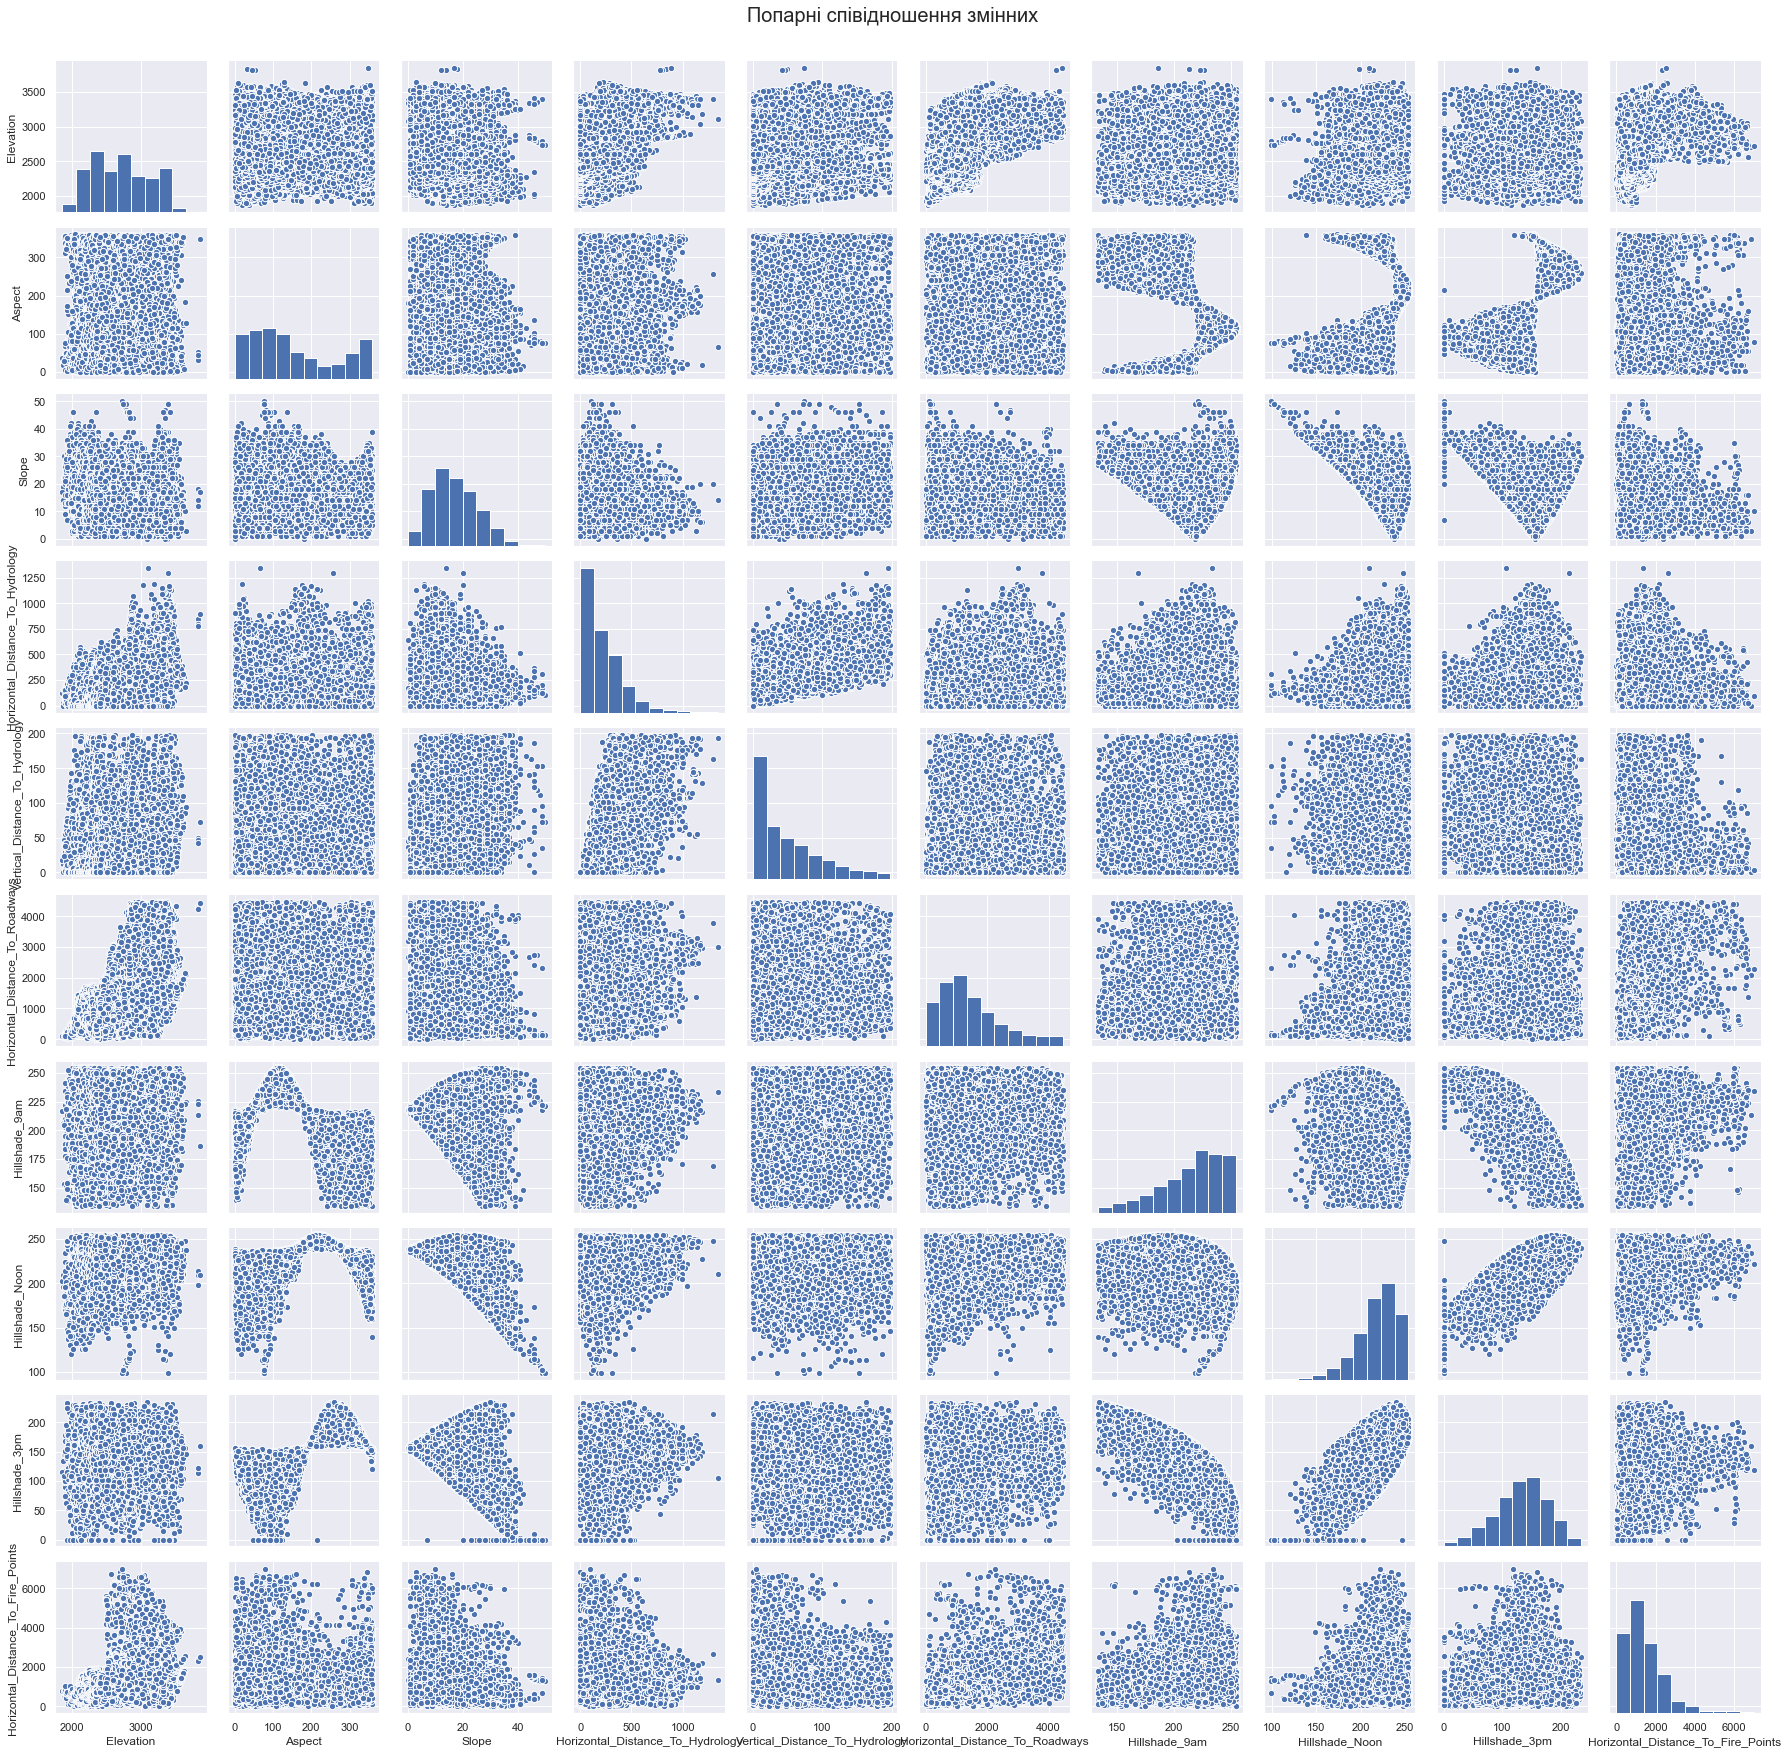

In [26]:
def pairwise_rel(data):
    sns.set()

    # Setting pairgrid
    g = sns.PairGrid(data)

    # Populating pairgrid
    mdg = g.map_diag(plt.hist, edgecolor="w")
    mog = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Попарні співідношення змінних", fontsize=20)

    plt.show()
    
pairwise_rel(df[num_cols])

Зробимо деякі перетворення перед поальшим аналізом

In [27]:
df.set_index('Id', inplace=True)

In [28]:
df_many.set_index('Id', inplace=True)
df_many.drop(columns={'count'}, inplace=True)

__Матриця кореляції__

З огляду на те, що таргетна змінна є категорійною та в датасеті присутні інші категорійні змінні, скористаємося _Phik_ замість коефіцієнта кореляції Пірсона або Спірмена

In [29]:
phik_overview = df_many.phik_matrix(interval_cols=num_cols)
phik_overview

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area
Elevation,1.000000,0.244584,0.362808,0.450691,0.280127,0.645437,0.314481,0.292785,0.312910,0.576335,0.804774,0.830256,0.778098
Aspect,0.244584,1.000000,0.229337,0.190672,0.089455,0.244695,0.860933,0.768351,0.840490,0.159183,0.305159,0.563309,0.292143
Slope,0.362808,0.229337,1.000000,0.218625,0.346807,0.288035,0.676864,0.875098,0.815220,0.271560,0.265557,0.542360,0.267777
Horizontal_Distance_To_Hydrology,0.450691,0.190672,0.218625,1.000000,0.669276,0.285481,0.167742,0.193104,0.206815,0.220897,0.299915,0.525495,0.258776
Vertical_Distance_To_Hydrology,0.280127,0.089455,0.346807,0.669276,1.000000,0.147356,0.221389,0.256040,0.267597,0.151822,0.223640,0.415022,0.139321
Horizontal_Distance_To_Roadways,0.645437,0.244695,0.288035,0.285481,0.147356,1.000000,0.228192,0.304563,0.308463,0.562216,0.492329,0.604135,0.548964
Hillshade_9am,0.314481,0.860933,0.676864,0.167742,0.221389,0.228192,1.000000,0.367769,0.831930,0.215287,0.340647,0.568596,0.305922
Hillshade_Noon,0.292785,0.768351,0.875098,0.193104,0.256040,0.304563,0.367769,1.000000,0.716276,0.177807,0.211865,0.468286,0.254338
Hillshade_3pm,0.312910,0.840490,0.815220,0.206815,0.267597,0.308463,0.831930,0.716276,1.000000,0.246881,0.272872,0.512690,0.267805
Horizontal_Distance_To_Fire_Points,0.576335,0.159183,0.271560,0.220897,0.151822,0.562216,0.215287,0.177807,0.246881,1.000000,0.432059,0.628024,0.523017


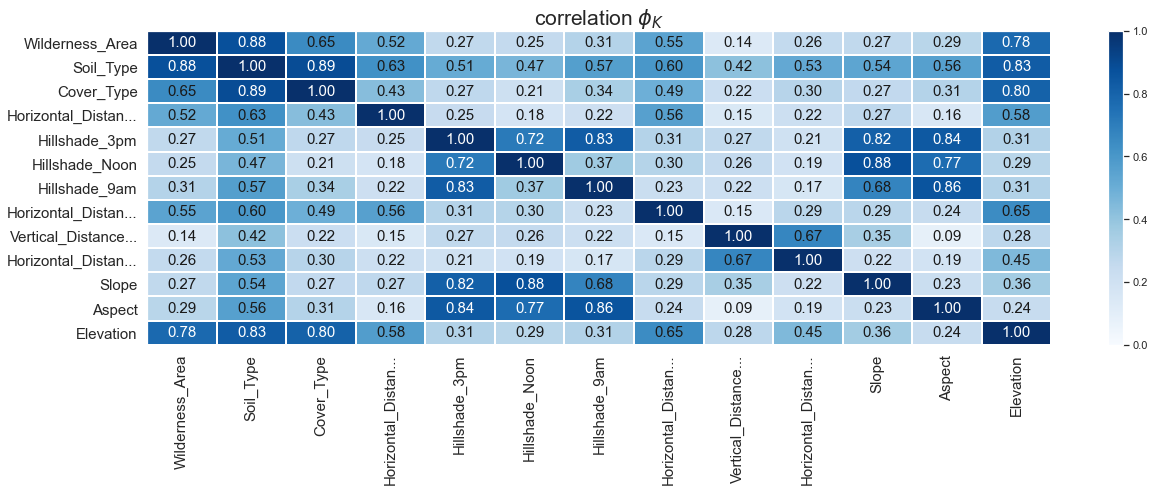

In [30]:
report.plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(18, 7))
plt.tight_layout()

Видаляємо _Hillshade_3pm_, як корелюючу з іншими _Hillshade_ та найменш корелюючу з таргетною змінною

In [31]:
df.drop(columns=['Hillshade_3pm'], inplace=True)
df_many.drop(columns=['Hillshade_3pm'], inplace=True)

### Використання класифікаторів

In [32]:
features_columns = [item for item in df_many.columns if item != 'Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(df_many[features_columns], df_many['Cover_Type'], test_size=0.2)

In [33]:
print('Розмір даних у тренувальному датасеті', X_train.shape)
print('Розмір даних у тестувальному датасеті', X_test.shape)

Розмір даних у тренувальному датасеті (9944, 11)
Розмір даних у тестувальному датасеті (2486, 11)


__Нормалізація даних__

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)

Побудуємо функцію оцінки моделі

In [35]:
def fit_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return accuracy_score(y_valid, y_predicted), y_predicted, model

Побудуємо функцію відображення матриці помилок

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Нормалізована матриця помилок'
        else:
            title = 'Матриця помилок без нормалізації'

    # обчислення матриці помилок
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [37]:
lgbm_classifier = LGBMClassifier()
lgbm_accuracy, y_predicted, model = fit_evaluate_model(lgbm_classifier, X_train_scaled, y_train, X_test_scaled, y_test)
print("Кількість коректних передбачень:", lgbm_accuracy)

Кількість коректних передбачень: 0.8511665325824618


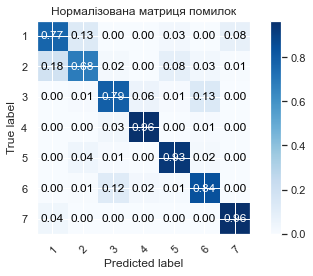

In [38]:
plot_confusion_matrix(y_test, y_predicted, classes=sorted(df_many['Cover_Type'].unique()), normalize=True,
                      title='Нормалізована матриця помилок')
plt.show()

Суттєві помилки в типах 1 та 2.

### Робота з тестовим датасетом

__Реформатування датасету__

Видалення колонки

In [39]:
df_test.drop(columns=['Hillshade_3pm'], inplace=True)
df_many = df_test.copy()

Додавання колонок з типом грунту та _Wilderness_

In [40]:
soil_types = ['Soil_Type' + str(n) for n in range(1, 41)]
df_soils = df_test[soil_types].copy()
df_soils['Soil_Type'] = (df_soils.iloc[:, 0:39] == 1).idxmax(1)
df_many['Soil_Type'] = df_soils['Soil_Type'].str.replace('Soil_Type', '').astype('int8')

In [41]:
wa = ['Wilderness_Area'  + str(n) for n in range(1, 5)]
df_wa = df_test[wa].copy()
df_wa['Wilderness_Area'] = (df_wa.iloc[:, 0:4] == 1).idxmax(1)
df_many['Wilderness_Area'] = df_wa['Wilderness_Area'].str.replace('Wilderness_Area', '').astype('int8')

In [42]:
df_many

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,...,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Soil_Type,Wilderness_Area
0,15121,2680,354,14,0,0,2684,196,214,6645,...,0,0,0,0,0,0,0,0,29,1
1,15122,2683,0,13,0,0,2654,201,216,6675,...,0,0,0,0,0,0,0,0,29,1
2,15123,2713,16,15,0,0,2980,206,208,6344,...,0,0,0,0,0,0,0,0,29,1
3,15124,2709,24,17,0,0,2950,208,201,6374,...,0,0,0,0,0,0,0,0,29,1
4,15125,2706,29,19,0,0,2920,210,195,6404,...,0,0,0,0,0,0,0,0,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565887,581008,2396,153,20,85,17,108,240,237,837,...,0,0,0,0,0,0,0,0,2,3
565888,581009,2391,152,19,67,12,95,240,237,845,...,0,0,0,0,0,0,0,0,2,3
565889,581010,2386,159,17,60,7,90,236,241,854,...,0,0,0,0,0,0,0,0,2,3
565890,581011,2384,170,15,60,5,90,230,245,864,...,0,0,0,0,0,0,0,0,2,3


Видалення бінарних стовпчиків

In [43]:
try:
    df_many.drop(columns=soil_types + wa, inplace=True)
except:
    pass
df_many = df_many[features_columns].copy()

__Виконання класифікації__

Отримання масиву ознак

In [44]:
X = np.array(df_many[[item for item in df_many.columns if item not in ['Cover_Type', 'Id']]])

Проведення стандартизації даних

In [45]:
X_scaled = scaler.transform(X)

Передбачення

In [46]:
y = model.predict(X_scaled)

__Підготовка вивантаження у потрібному форматі__

In [47]:
export_df = pd.DataFrame({'Id': df_test.Id, 'Cover_Type': y})
export_df.to_csv('submission.csv', index=False)

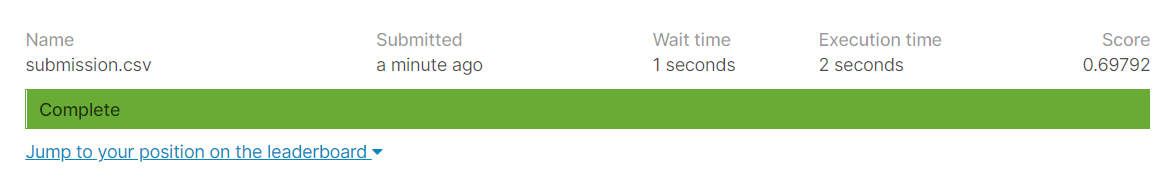
